# Predicting AirBnB bookings

Given various data about an AirBnB property, including items such as number of bedrooms, cost, and the economic situation of the surrounding area, we would like to see whether it's possible to predict the average booking rate of an AirBnB property.

To do this, we look at the following datasets:
- listings: information about each listing
- econ_state: economic information for each state
- calendar: day-to-day listing data for five cities

# Examining daily rental information for five cities

We would first like to see detailed rental information for a few cities, to get an idea of how things like price and availability change with location and time.

In [ ]:
calendar = pd.read_csv("Data/calendar.csv", parse_dates=["date"], index_col='date')

In [19]:
calendar.keys()

Index([u'listing_id', u'available', u'price', u'metro_area'], dtype='object')

In [21]:
calendar[:5]

,listing_id,available,price,metro_area
date,,,,
2018-03-05,2515,t,$69.00,NYC
2018-03-04,2515,t,$69.00,NYC
2018-03-03,2515,t,$69.00,NYC
2018-03-02,2515,t,$69.00,NYC
2018-03-01,2515,t,$69.00,NYC


We perform some light formatting.

In [22]:
# convert 't' and 'f' in dataset to 1 and 0
calendar['available'] = (calendar['available']=='t').astype(int)

In [24]:
# convert price to float
calendar['price'] = calendar['price'].replace('[\$,)]', '', regex=True).astype(float)

In [25]:
calendar[:5]

,listing_id,available,price,metro_area
date,,,,
2018-03-05,2515,1,69.0,NYC
2018-03-04,2515,1,69.0,NYC
2018-03-03,2515,1,69.0,NYC
2018-03-02,2515,1,69.0,NYC
2018-03-01,2515,1,69.0,NYC


In [26]:
calendar['metro_area'].unique()

array(['NYC', 'denver', 'chicago', 'boston', 'dc'], dtype=object)

In [27]:
# the average rental price for each city
calendar.groupby('metro_area')['price'].aggregate(np.mean)

metro_area
NYC        165.904913
boston     198.438909
chicago    167.022702
dc         243.322393
denver     145.892388
Name: price, dtype: float64

Each unique property has one listing for each day that it's on AirBnB. We would like to rebin so that we get the average availability and price for each property on a monthly basis.

In [28]:
unique_calendar = calendar.groupby([pd.TimeGrouper('M'), 'metro_area', 'listing_id']).aggregate(np.mean)

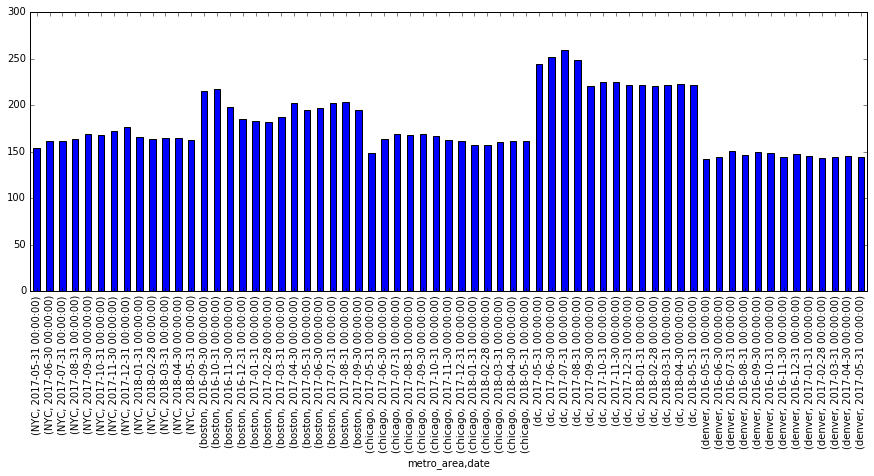

In [30]:
# all 5 cities shown below - monthly average price by all listings
price = unique_calendar.groupby(level=['metro_area', 'date']).mean().dropna()['price']
price.plot(kind='bar', figsize=(15,5))

In the above plot we see the average rental price as a function of time for each city. For example, for NYC we have monthly data from May 2017 to May 2018, and we see that the average price hovered around $160. One thing we notice is that while prices may differ by a large amount between cities, the average price within a city does not change much as a function of time. This means that when extracting information such as city or state GDP, we should pay more attention to location than to the year. This is fortunate, since our yearly state economics dataset does not coincide in time with most of our listings data.

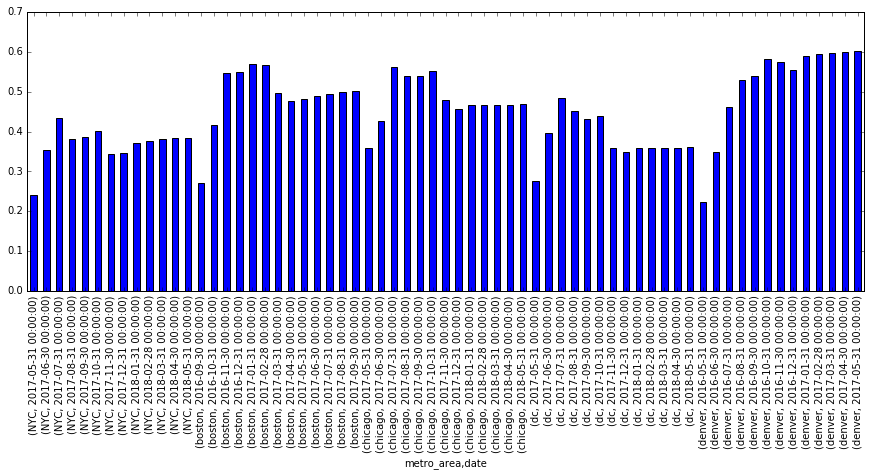

In [33]:
# all 5 cities shown below - monthly average availability by all listings
availability = unique_calendar.groupby(level=['metro_area', 'date']).mean().dropna()['available']
availability.plot(kind='bar', figsize=(15,5))

From the availability plot we see that each city sees roughly the same trend in availability over the course of a year. Availability is lowest (meaning that bookings are highest) around May. There are large differences in availability for different cities. Combined with the previous plot, this demonstrates that rental rates fluctuate by a large amount with the month, though we would not be able to determine these changes from

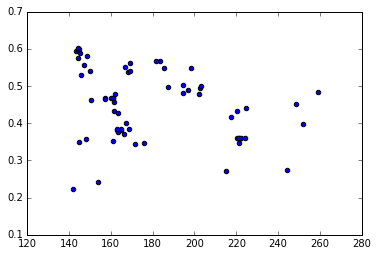

In [34]:
# monthly price vs. availability by all unique listings
plt.scatter(price, availability)
del price, availability

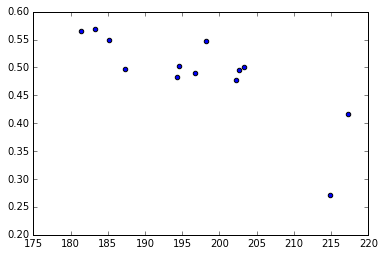

In [35]:
# monthly price vs. availability by all unique listings for Boston
metro = 'boston'
metro_unique_calendar = unique_calendar.xs(metro, level='metro_area', drop_level=True)
price = metro_unique_calendar.groupby(level=['date']).mean().dropna()['price']
availability = metro_unique_calendar.groupby(level=['date']).mean().dropna()['available']
plt.scatter(price, availability)
del price, availability

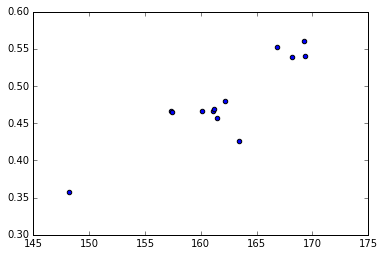

In [38]:
# monthly price vs. availability by all unique listings for Chicago
metro = 'chicago'
metro_unique_calendar = unique_calendar.xs(metro, level='metro_area', drop_level=True)
price = metro_unique_calendar.groupby(level=['date']).mean().dropna()['price']
availability = metro_unique_calendar.groupby(level=['date']).mean().dropna()['available']
plt.scatter(price, availability)
del price, availability

There appears to be little correlation between price and availability when looking across all data, but the difference between cities is surprisingly large. In Boston the most expensive properties are the ones which are booked most often, while in Chicago the opposite is true. This indicates that location data should play a very large role in predicting rental rates.

# Loading and cleaning listings dataset

This dataset shows around 60k listings along the U.S. midwest and northeast. Information such as number of beds, the location, and the rental price are shown.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
pd.set_option('display.max_columns', None)
listings = pd.read_csv("Data/listings.csv")

In [3]:
listings

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,100.0,10.0,Private room,NY,NaN,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Private room,NY,NaN,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NY,NaN,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,NaN,...,10.0,10.0,10.0,10.0,93.0,10.0,Entire home/apt,NY,$775.00,10464
4,4.0,"{Internet,""Wireless Internet"",""Air conditionin...",17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,97.0,10.0,Private room,NY,$350.00,10464
5,2.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",23,1.0,Real Bed,0.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,97.0,10.0,Entire home/apt,NY,$550.00,10464
6,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",15,1.0,Real Bed,1.0,2.0,flexible,long island city,NaN,...,10.0,10.0,10.0,10.0,98.0,10.0,Entire home/apt,NY,NaN,10464
7,3.0,"{""Cable TV"",Internet,""Wireless Internet"",""Air ...",5,1.0,Real Bed,1.0,2.0,strict,sunnysidebronx,NaN,...,9.0,9.0,9.0,9.0,90.0,9.0,Private room,NY,NaN,10467
8,5.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,NY,NaN,10469
9,8.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",12,1.0,Real Bed,1.0,3.0,strict,sunnysidebronx,NaN,...,10.0,9.0,10.0,9.0,92.0,9.0,Entire home/apt,NY,NaN,10469


There is a lot of interesting information here, but it requires extensive cleaning before it's useable. For instance, we would like to convert the amenities list to a categorical format. In other words, we would like to create columns labelled has_cable, has_wifi, etc.

# Cleaning and merging data

In [11]:
listings = listings[['accommodates', 'bathrooms', 'beds', 'availability_30']]

# Predicting booking rate with a neural net

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [5]:
# set random seed for reproducibility
random_seed = 13
np.random.seed(random_seed)

In [14]:
# shuffle and split into test and train
from sklearn.utils import shuffle
listings = shuffle(listings)
listings = listings.dropna()

from __future__ import division
X = listings.drop('availability_30', 1)
y = listings['availability_30']

testRatio = 0.2
nSamples = len(X)
nTest = int(nSamples * testRatio)

X_test = X[:nTest].values
y_test = y[:nTest].values
X_train = X[nTest:].values
y_train = y[nTest:].values
del listings, X, y

NameError: name 'listings' is not defined

In [16]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, init='normal'))
model.add(Dropout(0.5))
model.add(Dense(1, init='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal", input_dim=3)`
  from ipykernel import kernelapp as app
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="normal")`
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`


In [18]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

Train on 47597 samples, validate on 11899 samples
Epoch 1/20
47597/47597 [==============================] - 2s - loss: 127.7581 - val_loss: 104.6346
Epoch 2/20
47597/47597 [==============================] - 1s - loss: 111.6049 - val_loss: 101.4066
Epoch 3/20
47597/47597 [==============================] - 1s - loss: 108.5065 - val_loss: 100.6106
Epoch 4/20
47597/47597 [==============================] - 1s - loss: 107.4578 - val_loss: 99.6778
Epoch 5/20
47597/47597 [==============================] - 1s - loss: 106.1336 - val_loss: 99.8002
Epoch 6/20
47597/47597 [==============================] - 1s - loss: 105.4632 - val_loss: 99.6888
Epoch 7/20
47597/47597 [==============================] - 1s - loss: 105.1057 - val_loss: 99.6493
Epoch 8/20
47597/47597 [==============================] - 1s - loss: 104.6477 - val_loss: 99.7276
Epoch 9/20
47597/47597 [==============================] - 1s - loss: 104.6542 - val_loss: 99.5362
Epoch 10/20
47597/47597 [==============================] - 1s - l